
Classification Report:
              precision    recall  f1-score   support

         0.0       0.84      0.99      0.91      1721
         1.0       0.93      0.45      0.60       586

    accuracy                           0.85      2307
   macro avg       0.88      0.72      0.76      2307
weighted avg       0.86      0.85      0.83      2307


Accuracy Score of the Random Forest model: 85.05%

Confusion Matrix:
[[1701   20]
 [ 325  261]]


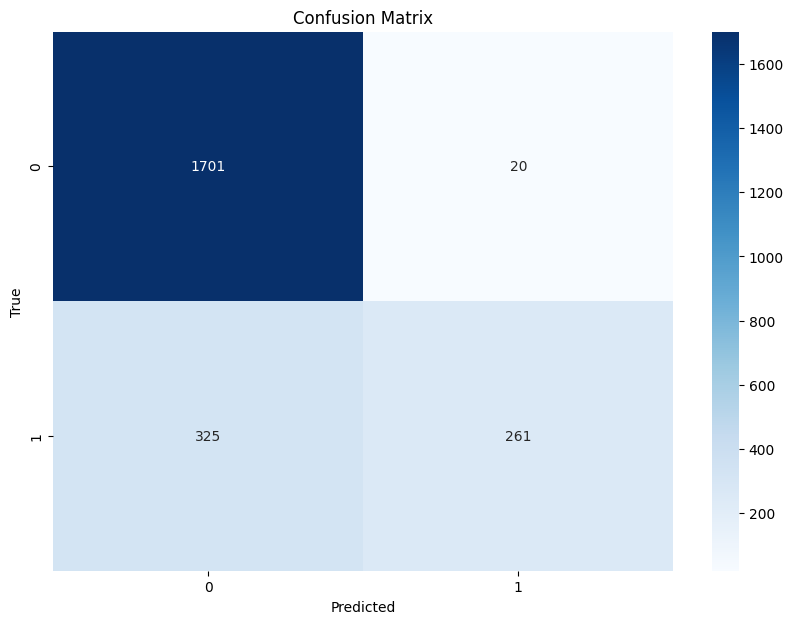

In [7]:
import pandas as pd
import numpy as np
from pymongo import MongoClient
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt

# Connect to MongoDB
client = MongoClient('mongodb://localhost:27017/')
db = client['thesis_db']  # Replace with your database name
collection = db['research_data']  # Replace with your collection name

# Retrieve data from MongoDB
data = list(collection.find())

# Convert to DataFrame
df = pd.DataFrame(data)

# Drop the MongoDB '_id' field if it exists
if '_id' in df.columns:
    df = df.drop('_id', axis=1)

# Data Cleaning
df.fillna(df.mean(numeric_only=True), inplace=True)
df.drop_duplicates(inplace=True)
numeric_cols = df.select_dtypes(include=[float, int]).columns

def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

for col in numeric_cols:
    df = remove_outliers_iqr(df, col)

scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
label_encoder = LabelEncoder()
df['Class/ASD'] = label_encoder.fit_transform(df['Class/ASD'])
df_encoded = pd.get_dummies(df, drop_first=True)
df_selected = df_encoded.select_dtypes(include=[np.number])

# PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_selected)
pca_df = pd.DataFrame(data=principal_components, columns=['Principal Component 1', 'Principal Component 2'])
pca_df.to_csv('pca_transformed_data.csv', index=False)

# Split the data into features and target
X = df_encoded.drop(columns=['Class/ASD'])
y = df['Class/ASD']

# Ensure the data is float32 for TensorFlow compatibility
X = X.astype('float32')
y = y.astype('float32')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply Random Forest model 
rf_model = RandomForestClassifier(n_estimators=5,        
                                  max_depth=3,           
                                  min_samples_split=10,  
                                  min_samples_leaf=5,    
                                  random_state=42)

# Fit the model to the training data
rf_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf_model.predict(X_test)

# Print classification report and accuracy
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy Score of the Random Forest model: {accuracy * 100:.2f}%")

# Print confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
